In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/80 [..............................] - ETA: 2:03 - loss: 0.2374 - STD: 1.9574e-04 - MAE: 0.4777

 4/80 [>.............................] - ETA: 2s - loss: 0.0819 - STD: 4.5911e-04 - MAE: 0.2225  

 5/80 [>.............................] - ETA: 2s - loss: 0.0690 - STD: 4.1250e-04 - MAE: 0.1978

 6/80 [=>............................] - ETA: 3s - loss: 0.0613 - STD: 3.6543e-04 - MAE: 0.1849

 7/80 [=>............................] - ETA: 3s - loss: 0.0563 - STD: 3.2459e-04 - MAE: 0.1773

 8/80 [==>...........................] - ETA: 3s - loss: 0.0529 - STD: 2.9029e-04 - MAE: 0.1727

 9/80 [==>...........................] - ETA: 3s - loss: 0.0502 - STD: 2.6173e-04 - MAE: 0.1692

10/80 [==>...........................] - ETA: 3s - loss: 0.0483 - STD: 2.3773e-04 - MAE: 0.1671

11/80 [===>..........................] - ETA: 3s - loss: 0.0467 - STD: 2.1742e-04 - MAE: 0.1653

12/80 [===>..........................] - ETA: 3s - loss: 0.0455 - STD: 2.0007e-04 - MAE: 0.1639

13/80 [===>..........................] - ETA: 3s - loss: 0.0443 - STD: 1.8517e-04 - MAE: 0.1627

14/80 [====>.........................] - ETA: 3s - loss: 0.0433 - STD: 1.7232e-04 - MAE: 0.1615

15/80 [====>.........................] - ETA: 3s - loss: 0.0424 - STD: 1.6122e-04 - MAE: 0.1604

16/80 [=====>........................] - ETA: 3s - loss: 0.0416 - STD: 1.5160e-04 - MAE: 0.1592

17/80 [=====>........................] - ETA: 3s - loss: 0.0408 - STD: 1.4321e-04 - MAE: 0.1580

18/80 [=====>........................] - ETA: 3s - loss: 0.0401 - STD: 1.3583e-04 - MAE: 0.1567

19/80 [======>.......................] - ETA: 3s - loss: 0.0393 - STD: 1.2932e-04 - MAE: 0.1553

20/80 [======>.......................] - ETA: 3s - loss: 0.0385 - STD: 1.2355e-04 - MAE: 0.1537

21/80 [======>.......................] - ETA: 3s - loss: 0.0377 - STD: 1.1842e-04 - MAE: 0.1519

22/80 [=======>......................] - ETA: 3s - loss: 0.0369 - STD: 1.1385e-04 - MAE: 0.1500

23/80 [=======>......................] - ETA: 3s - loss: 0.0361 - STD: 1.0978e-04 - MAE: 0.1479

24/80 [========>.....................] - ETA: 3s - loss: 0.0353 - STD: 1.0615e-04 - MAE: 0.1456

25/80 [========>.....................] - ETA: 3s - loss: 0.0344 - STD: 1.0290e-04 - MAE: 0.1432

26/80 [========>.....................] - ETA: 2s - loss: 0.0335 - STD: 1.0001e-04 - MAE: 0.1407

27/80 [=========>....................] - ETA: 2s - loss: 0.0327 - STD: 9.7434e-05 - MAE: 0.1382

28/80 [=========>....................] - ETA: 2s - loss: 0.0319 - STD: 9.5113e-05 - MAE: 0.1359

29/80 [=========>....................] - ETA: 2s - loss: 0.0311 - STD: 9.3008e-05 - MAE: 0.1338

30/80 [==========>...................] - ETA: 2s - loss: 0.0303 - STD: 9.1067e-05 - MAE: 0.1320

31/80 [==========>...................] - ETA: 2s - loss: 0.0297 - STD: 8.9268e-05 - MAE: 0.1305

32/80 [===========>..................] - ETA: 2s - loss: 0.0291 - STD: 8.7548e-05 - MAE: 0.1292

33/80 [===========>..................] - ETA: 2s - loss: 0.0286 - STD: 8.5905e-05 - MAE: 0.1281

34/80 [===========>..................] - ETA: 2s - loss: 0.0281 - STD: 8.4317e-05 - MAE: 0.1271

35/80 [============>.................] - ETA: 2s - loss: 0.0277 - STD: 8.2752e-05 - MAE: 0.1262

36/80 [============>.................] - ETA: 2s - loss: 0.0272 - STD: 8.1201e-05 - MAE: 0.1252

37/80 [============>.................] - ETA: 2s - loss: 0.0268 - STD: 7.9650e-05 - MAE: 0.1243

38/80 [=============>................] - ETA: 2s - loss: 0.0264 - STD: 7.8107e-05 - MAE: 0.1232

39/80 [=============>................] - ETA: 2s - loss: 0.0259 - STD: 7.6570e-05 - MAE: 0.1221

40/80 [==============>...............] - ETA: 2s - loss: 0.0255 - STD: 7.5041e-05 - MAE: 0.1210

41/80 [==============>...............] - ETA: 2s - loss: 0.0251 - STD: 7.3528e-05 - MAE: 0.1199

42/80 [==============>...............] - ETA: 2s - loss: 0.0247 - STD: 7.2042e-05 - MAE: 0.1188

43/80 [===============>..............] - ETA: 2s - loss: 0.0244 - STD: 7.0591e-05 - MAE: 0.1178

44/80 [===============>..............] - ETA: 2s - loss: 0.0243 - STD: 6.9181e-05 - MAE: 0.1167

47/80 [================>.............] - ETA: 2s - loss: 0.0234 - STD: 6.5248e-05 - MAE: 0.1140

49/80 [=================>............] - ETA: 2s - loss: 0.0228 - STD: 6.2876e-05 - MAE: 0.1124

50/80 [=================>............] - ETA: 2s - loss: 0.0225 - STD: 6.1764e-05 - MAE: 0.1116

51/80 [==================>...........] - ETA: 1s - loss: 0.0223 - STD: 6.0699e-05 - MAE: 0.1109

52/80 [==================>...........] - ETA: 1s - loss: 0.0220 - STD: 5.9679e-05 - MAE: 0.1101

53/80 [==================>...........] - ETA: 1s - loss: 0.0218 - STD: 5.8705e-05 - MAE: 0.1095

54/80 [===================>..........] - ETA: 1s - loss: 0.0216 - STD: 5.7772e-05 - MAE: 0.1088

55/80 [===================>..........] - ETA: 1s - loss: 0.0213 - STD: 5.6877e-05 - MAE: 0.1082

56/80 [====================>.........] - ETA: 1s - loss: 0.0211 - STD: 5.6022e-05 - MAE: 0.1076

57/80 [====================>.........] - ETA: 1s - loss: 0.0209 - STD: 5.5203e-05 - MAE: 0.1071

58/80 [====================>.........] - ETA: 1s - loss: 0.0207 - STD: 5.4418e-05 - MAE: 0.1066

59/80 [=====================>........] - ETA: 1s - loss: 0.0205 - STD: 5.3662e-05 - MAE: 0.1061

60/80 [=====================>........] - ETA: 1s - loss: 0.0203 - STD: 5.2932e-05 - MAE: 0.1056

61/80 [=====================>........] - ETA: 1s - loss: 0.0201 - STD: 5.2227e-05 - MAE: 0.1052

62/80 [======================>.......] - ETA: 1s - loss: 0.0200 - STD: 5.1543e-05 - MAE: 0.1048

63/80 [======================>.......] - ETA: 1s - loss: 0.0198 - STD: 5.0882e-05 - MAE: 0.1043

64/80 [=======================>......] - ETA: 1s - loss: 0.0196 - STD: 5.0239e-05 - MAE: 0.1039

65/80 [=======================>......] - ETA: 0s - loss: 0.0195 - STD: 4.9615e-05 - MAE: 0.1035

66/80 [=======================>......] - ETA: 0s - loss: 0.0193 - STD: 4.9008e-05 - MAE: 0.1031

67/80 [========================>.....] - ETA: 0s - loss: 0.0192 - STD: 4.8419e-05 - MAE: 0.1027

68/80 [========================>.....] - ETA: 0s - loss: 0.0190 - STD: 4.7846e-05 - MAE: 0.1022

69/80 [========================>.....] - ETA: 0s - loss: 0.0189 - STD: 4.7290e-05 - MAE: 0.1018

70/80 [=========================>....] - ETA: 0s - loss: 0.0187 - STD: 4.6752e-05 - MAE: 0.1015

71/80 [=========================>....] - ETA: 0s - loss: 0.0186 - STD: 4.6231e-05 - MAE: 0.1011

72/80 [==========================>...] - ETA: 0s - loss: 0.0185 - STD: 4.5724e-05 - MAE: 0.1007

73/80 [==========================>...] - ETA: 0s - loss: 0.0183 - STD: 4.5232e-05 - MAE: 0.1004

74/80 [==========================>...] - ETA: 0s - loss: 0.0182 - STD: 4.4754e-05 - MAE: 0.1000

75/80 [===========================>..] - ETA: 0s - loss: 0.0181 - STD: 4.4293e-05 - MAE: 0.0997

76/80 [===========================>..] - ETA: 0s - loss: 0.0180 - STD: 4.3847e-05 - MAE: 0.0994

77/80 [===========================>..] - ETA: 0s - loss: 0.0179 - STD: 4.3415e-05 - MAE: 0.0990

78/80 [============================>.] - ETA: 0s - loss: 0.0178 - STD: 4.2997e-05 - MAE: 0.0987

79/80 [============================>.] - ETA: 0s - loss: 0.0176 - STD: 4.2591e-05 - MAE: 0.0985

80/80 [==============================] - ETA: 0s - loss: 0.0175 - STD: 4.2197e-05 - MAE: 0.0982

80/80 [==============================] - 7s 73ms/step - loss: 0.0175 - STD: 4.2197e-05 - MAE: 0.0982 - val_loss: 0.0086 - val_STD: 6.9491e-06 - val_MAE: 0.0717


Epoch 2/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0089 - STD: 1.1469e-05 - MAE: 0.0746

 2/80 [..............................] - ETA: 5s - loss: 0.0091 - STD: 1.1611e-05 - MAE: 0.0754

 3/80 [>.............................] - ETA: 5s - loss: 0.0092 - STD: 1.1698e-05 - MAE: 0.0758

 4/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 1.1748e-05 - MAE: 0.0760

 5/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 1.1833e-05 - MAE: 0.0758

 6/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.1916e-05 - MAE: 0.0759

 7/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.2020e-05 - MAE: 0.0760

 8/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.2113e-05 - MAE: 0.0759

 9/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.2205e-05 - MAE: 0.0759

10/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.2299e-05 - MAE: 0.0759

11/80 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 1.2377e-05 - MAE: 0.0758

13/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.2532e-05 - MAE: 0.0756

14/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.2618e-05 - MAE: 0.0756

15/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.2705e-05 - MAE: 0.0756

16/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.2794e-05 - MAE: 0.0755

17/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.2880e-05 - MAE: 0.0754

18/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.2980e-05 - MAE: 0.0755

19/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.3077e-05 - MAE: 0.0755

20/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.3185e-05 - MAE: 0.0755

21/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.3297e-05 - MAE: 0.0755

22/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.3407e-05 - MAE: 0.0756

23/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.3515e-05 - MAE: 0.0756

24/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.3624e-05 - MAE: 0.0756

25/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.3740e-05 - MAE: 0.0756

26/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.3859e-05 - MAE: 0.0756

27/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 1.3981e-05 - MAE: 0.0756

28/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 1.4107e-05 - MAE: 0.0756

29/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.4231e-05 - MAE: 0.0756

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.4349e-05 - MAE: 0.0756

31/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.4470e-05 - MAE: 0.0756

32/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.4598e-05 - MAE: 0.0756

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.4725e-05 - MAE: 0.0756

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.4851e-05 - MAE: 0.0755

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.4981e-05 - MAE: 0.0755

36/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.5114e-05 - MAE: 0.0755

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.5244e-05 - MAE: 0.0755

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.5376e-05 - MAE: 0.0755

39/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.5508e-05 - MAE: 0.0755

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.5646e-05 - MAE: 0.0755

41/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.5787e-05 - MAE: 0.0754

42/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.5936e-05 - MAE: 0.0754

43/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.6080e-05 - MAE: 0.0754

44/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.6233e-05 - MAE: 0.0754

45/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.6383e-05 - MAE: 0.0754

46/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.6539e-05 - MAE: 0.0754

47/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.6697e-05 - MAE: 0.0754

48/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.6849e-05 - MAE: 0.0753

49/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.7006e-05 - MAE: 0.0753

50/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.7169e-05 - MAE: 0.0753

51/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.7331e-05 - MAE: 0.0753

52/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.7498e-05 - MAE: 0.0754

53/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.7666e-05 - MAE: 0.0754

54/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.7836e-05 - MAE: 0.0754

55/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.8014e-05 - MAE: 0.0754

56/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.8186e-05 - MAE: 0.0754

57/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.8363e-05 - MAE: 0.0754

58/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.8544e-05 - MAE: 0.0754

59/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.8728e-05 - MAE: 0.0754

60/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.8917e-05 - MAE: 0.0754

61/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.9106e-05 - MAE: 0.0753

62/80 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 1.9299e-05 - MAE: 0.0753

63/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.9498e-05 - MAE: 0.0754

64/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.9695e-05 - MAE: 0.0754

65/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.9897e-05 - MAE: 0.0754

66/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 2.0108e-05 - MAE: 0.0754

67/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.0319e-05 - MAE: 0.0754

68/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.0527e-05 - MAE: 0.0754

69/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.0747e-05 - MAE: 0.0754

70/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.0969e-05 - MAE: 0.0754

71/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.1191e-05 - MAE: 0.0754

72/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.1419e-05 - MAE: 0.0754

73/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.1651e-05 - MAE: 0.0754

74/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.1888e-05 - MAE: 0.0754

75/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 2.2127e-05 - MAE: 0.0754

76/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 2.2371e-05 - MAE: 0.0754

77/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 2.2615e-05 - MAE: 0.0754

78/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.2865e-05 - MAE: 0.0754

79/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.3121e-05 - MAE: 0.0754

80/80 [==============================] - ETA: 0s - loss: 0.0092 - STD: 2.3374e-05 - MAE: 0.0754

80/80 [==============================] - 5s 62ms/step - loss: 0.0092 - STD: 2.3374e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 3.0474e-05 - val_MAE: 0.0714


Epoch 3/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0090 - STD: 4.4866e-05 - MAE: 0.0747

 2/80 [..............................] - ETA: 4s - loss: 0.0090 - STD: 4.4870e-05 - MAE: 0.0746

 3/80 [>.............................] - ETA: 5s - loss: 0.0091 - STD: 4.5461e-05 - MAE: 0.0747

 4/80 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 4.5962e-05 - MAE: 0.0749

 5/80 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 4.6405e-05 - MAE: 0.0748

 6/80 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 4.6871e-05 - MAE: 0.0748

 7/80 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 4.7397e-05 - MAE: 0.0748

 8/80 [==>...........................] - ETA: 4s - loss: 0.0091 - STD: 4.7947e-05 - MAE: 0.0748

 9/80 [==>...........................] - ETA: 4s - loss: 0.0091 - STD: 4.8424e-05 - MAE: 0.0748

10/80 [==>...........................] - ETA: 4s - loss: 0.0091 - STD: 4.8904e-05 - MAE: 0.0749

11/80 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.9410e-05 - MAE: 0.0750

12/80 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.9944e-05 - MAE: 0.0750

13/80 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 5.0523e-05 - MAE: 0.0751

14/80 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 5.1076e-05 - MAE: 0.0752

15/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 5.1602e-05 - MAE: 0.0752

16/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 5.2207e-05 - MAE: 0.0753

17/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 5.2815e-05 - MAE: 0.0753

18/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 5.3400e-05 - MAE: 0.0754

19/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 5.4010e-05 - MAE: 0.0754

20/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 5.4647e-05 - MAE: 0.0754

21/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 5.5282e-05 - MAE: 0.0754

23/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 5.6535e-05 - MAE: 0.0753

24/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 5.7175e-05 - MAE: 0.0753

25/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 5.7821e-05 - MAE: 0.0752

26/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 5.8494e-05 - MAE: 0.0752

27/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 5.9194e-05 - MAE: 0.0752

28/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 5.9874e-05 - MAE: 0.0752

29/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 6.0596e-05 - MAE: 0.0752

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 6.1367e-05 - MAE: 0.0752

31/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 6.2143e-05 - MAE: 0.0752

32/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.2947e-05 - MAE: 0.0753

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.3729e-05 - MAE: 0.0753

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.4560e-05 - MAE: 0.0753

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 6.5392e-05 - MAE: 0.0753

36/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 6.6242e-05 - MAE: 0.0753

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 6.7084e-05 - MAE: 0.0753

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 6.7957e-05 - MAE: 0.0753

39/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 6.8847e-05 - MAE: 0.0754

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 6.9753e-05 - MAE: 0.0754

41/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 7.0724e-05 - MAE: 0.0754

42/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 7.1708e-05 - MAE: 0.0754

43/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 7.2702e-05 - MAE: 0.0754

44/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 7.3687e-05 - MAE: 0.0754

45/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 7.4704e-05 - MAE: 0.0754

46/80 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 7.5741e-05 - MAE: 0.0754

47/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 7.6788e-05 - MAE: 0.0753

48/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 7.7862e-05 - MAE: 0.0753

49/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 7.8982e-05 - MAE: 0.0753

50/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 8.0130e-05 - MAE: 0.0753

51/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 8.1326e-05 - MAE: 0.0753

52/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 8.2520e-05 - MAE: 0.0753

53/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 8.3765e-05 - MAE: 0.0753

54/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 8.5053e-05 - MAE: 0.0753

55/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 8.6380e-05 - MAE: 0.0753

56/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 8.7727e-05 - MAE: 0.0753

57/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 8.9116e-05 - MAE: 0.0753

58/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 9.0530e-05 - MAE: 0.0753

59/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 9.2010e-05 - MAE: 0.0753

60/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 9.3535e-05 - MAE: 0.0753

61/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 9.5066e-05 - MAE: 0.0753

62/80 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 9.6687e-05 - MAE: 0.0753

63/80 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 9.8324e-05 - MAE: 0.0753

64/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.0001e-04 - MAE: 0.0753

65/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.0179e-04 - MAE: 0.0753

66/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.0355e-04 - MAE: 0.0753

67/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.0542e-04 - MAE: 0.0753

68/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.0732e-04 - MAE: 0.0753

69/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.0931e-04 - MAE: 0.0753

70/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.1131e-04 - MAE: 0.0753

71/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.1341e-04 - MAE: 0.0753

72/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.1556e-04 - MAE: 0.0753

73/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.1777e-04 - MAE: 0.0753

74/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.2002e-04 - MAE: 0.0753

75/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.2237e-04 - MAE: 0.0753

76/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.2479e-04 - MAE: 0.0753

77/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.2730e-04 - MAE: 0.0753

78/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.2989e-04 - MAE: 0.0753

79/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.3256e-04 - MAE: 0.0753

80/80 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.3535e-04 - MAE: 0.0753

80/80 [==============================] - 5s 63ms/step - loss: 0.0092 - STD: 1.3535e-04 - MAE: 0.0753 - val_loss: 0.0086 - val_STD: 2.4777e-04 - val_MAE: 0.0714


Epoch 4/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0092 - STD: 3.7062e-04 - MAE: 0.0755

 2/80 [..............................] - ETA: 4s - loss: 0.0093 - STD: 3.7464e-04 - MAE: 0.0756

 3/80 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 3.8252e-04 - MAE: 0.0757

 4/80 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 3.9007e-04 - MAE: 0.0755

 5/80 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 3.9809e-04 - MAE: 0.0755

 6/80 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 4.0575e-04 - MAE: 0.0755

 7/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 4.1287e-04 - MAE: 0.0754

 8/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 4.2085e-04 - MAE: 0.0754

 9/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 4.2855e-04 - MAE: 0.0753

10/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 4.3699e-04 - MAE: 0.0754

11/80 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.4556e-04 - MAE: 0.0754

12/80 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.5490e-04 - MAE: 0.0755

13/80 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.6459e-04 - MAE: 0.0755

14/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 4.7433e-04 - MAE: 0.0755

15/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 4.8423e-04 - MAE: 0.0755

16/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 4.9503e-04 - MAE: 0.0755

17/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 5.0614e-04 - MAE: 0.0755

18/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 5.1800e-04 - MAE: 0.0754

19/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 5.3006e-04 - MAE: 0.0754

20/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 5.4203e-04 - MAE: 0.0754

21/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 5.5468e-04 - MAE: 0.0753

22/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 5.6777e-04 - MAE: 0.0752

23/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 5.8155e-04 - MAE: 0.0752

24/80 [========>.....................] - ETA: 3s - loss: 0.0091 - STD: 5.9547e-04 - MAE: 0.0752

25/80 [========>.....................] - ETA: 3s - loss: 0.0091 - STD: 6.0969e-04 - MAE: 0.0752

26/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 6.2483e-04 - MAE: 0.0752

27/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 6.4036e-04 - MAE: 0.0752

28/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 6.5623e-04 - MAE: 0.0752

29/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 6.7288e-04 - MAE: 0.0752

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 6.9034e-04 - MAE: 0.0752

31/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 7.0896e-04 - MAE: 0.0753

32/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 7.2718e-04 - MAE: 0.0752

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 7.4639e-04 - MAE: 0.0753

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 7.6674e-04 - MAE: 0.0753

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 7.8756e-04 - MAE: 0.0753

36/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 8.0906e-04 - MAE: 0.0752

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 8.3117e-04 - MAE: 0.0752

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 8.5389e-04 - MAE: 0.0752

39/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 8.7802e-04 - MAE: 0.0752

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 9.0330e-04 - MAE: 0.0752

41/80 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 9.2934e-04 - MAE: 0.0752

42/80 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 9.5627e-04 - MAE: 0.0751

43/80 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 9.8391e-04 - MAE: 0.0751

44/80 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751    

45/80 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751

46/80 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

47/80 [================>.............] - ETA: 1s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

48/80 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

49/80 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0751

50/80 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750

51/80 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750

52/80 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0750

54/80 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0749

55/80 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0749

56/80 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0749

57/80 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0749

58/80 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0748

59/80 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0748

60/80 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0748

61/80 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0748

62/80 [======================>.......] - ETA: 1s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0748

63/80 [======================>.......] - ETA: 1s - loss: 0.0090 - STD: 0.0018 - MAE: 0.0748

64/80 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.0019 - MAE: 0.0747

65/80 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.0020 - MAE: 0.0747

66/80 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.0020 - MAE: 0.0747

67/80 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0021 - MAE: 0.0747

68/80 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0747

69/80 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0746

70/80 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0746

71/80 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0024 - MAE: 0.0746

72/80 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0025 - MAE: 0.0746

73/80 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0746

74/80 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0746

75/80 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0027 - MAE: 0.0745

76/80 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0028 - MAE: 0.0745

77/80 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0745

78/80 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0030 - MAE: 0.0745

79/80 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0031 - MAE: 0.0745

80/80 [==============================] - ETA: 0s - loss: 0.0090 - STD: 0.0032 - MAE: 0.0745

80/80 [==============================] - 5s 62ms/step - loss: 0.0090 - STD: 0.0032 - MAE: 0.0745 - val_loss: 0.0077 - val_STD: 0.0081 - val_MAE: 0.0682


Epoch 5/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0081 - STD: 0.0123 - MAE: 0.0714

 2/80 [..............................] - ETA: 4s - loss: 0.0082 - STD: 0.0126 - MAE: 0.0716

 3/80 [>.............................] - ETA: 4s - loss: 0.0082 - STD: 0.0128 - MAE: 0.0716

 4/80 [>.............................] - ETA: 4s - loss: 0.0082 - STD: 0.0130 - MAE: 0.0717

 5/80 [>.............................] - ETA: 4s - loss: 0.0083 - STD: 0.0133 - MAE: 0.0718

 6/80 [=>............................] - ETA: 4s - loss: 0.0082 - STD: 0.0135 - MAE: 0.0717

 7/80 [=>............................] - ETA: 4s - loss: 0.0082 - STD: 0.0138 - MAE: 0.0716

 8/80 [==>...........................] - ETA: 4s - loss: 0.0082 - STD: 0.0141 - MAE: 0.0716

 9/80 [==>...........................] - ETA: 4s - loss: 0.0082 - STD: 0.0144 - MAE: 0.0715

10/80 [==>...........................] - ETA: 4s - loss: 0.0082 - STD: 0.0146 - MAE: 0.0714

11/80 [===>..........................] - ETA: 4s - loss: 0.0082 - STD: 0.0149 - MAE: 0.0714

12/80 [===>..........................] - ETA: 4s - loss: 0.0081 - STD: 0.0152 - MAE: 0.0713

13/80 [===>..........................] - ETA: 4s - loss: 0.0081 - STD: 0.0155 - MAE: 0.0713

14/80 [====>.........................] - ETA: 4s - loss: 0.0081 - STD: 0.0158 - MAE: 0.0713

15/80 [====>.........................] - ETA: 3s - loss: 0.0081 - STD: 0.0161 - MAE: 0.0712

16/80 [=====>........................] - ETA: 3s - loss: 0.0081 - STD: 0.0165 - MAE: 0.0712

17/80 [=====>........................] - ETA: 3s - loss: 0.0081 - STD: 0.0168 - MAE: 0.0711

18/80 [=====>........................] - ETA: 3s - loss: 0.0080 - STD: 0.0171 - MAE: 0.0710

19/80 [======>.......................] - ETA: 3s - loss: 0.0080 - STD: 0.0174 - MAE: 0.0709

20/80 [======>.......................] - ETA: 3s - loss: 0.0080 - STD: 0.0178 - MAE: 0.0708

21/80 [======>.......................] - ETA: 3s - loss: 0.0080 - STD: 0.0181 - MAE: 0.0708

22/80 [=======>......................] - ETA: 3s - loss: 0.0080 - STD: 0.0184 - MAE: 0.0708

23/80 [=======>......................] - ETA: 3s - loss: 0.0080 - STD: 0.0187 - MAE: 0.0707

25/80 [========>.....................] - ETA: 3s - loss: 0.0080 - STD: 0.0194 - MAE: 0.0706

26/80 [========>.....................] - ETA: 3s - loss: 0.0080 - STD: 0.0197 - MAE: 0.0705

27/80 [=========>....................] - ETA: 3s - loss: 0.0079 - STD: 0.0200 - MAE: 0.0705

28/80 [=========>....................] - ETA: 3s - loss: 0.0079 - STD: 0.0203 - MAE: 0.0704

29/80 [=========>....................] - ETA: 2s - loss: 0.0079 - STD: 0.0206 - MAE: 0.0703

30/80 [==========>...................] - ETA: 2s - loss: 0.0079 - STD: 0.0209 - MAE: 0.0703

31/80 [==========>...................] - ETA: 2s - loss: 0.0079 - STD: 0.0212 - MAE: 0.0702

32/80 [===========>..................] - ETA: 2s - loss: 0.0079 - STD: 0.0215 - MAE: 0.0701

33/80 [===========>..................] - ETA: 2s - loss: 0.0079 - STD: 0.0218 - MAE: 0.0701

34/80 [===========>..................] - ETA: 2s - loss: 0.0078 - STD: 0.0221 - MAE: 0.0700

35/80 [============>.................] - ETA: 2s - loss: 0.0078 - STD: 0.0224 - MAE: 0.0700

36/80 [============>.................] - ETA: 2s - loss: 0.0078 - STD: 0.0227 - MAE: 0.0699

37/80 [============>.................] - ETA: 2s - loss: 0.0078 - STD: 0.0230 - MAE: 0.0698

38/80 [=============>................] - ETA: 2s - loss: 0.0078 - STD: 0.0233 - MAE: 0.0698

39/80 [=============>................] - ETA: 2s - loss: 0.0078 - STD: 0.0236 - MAE: 0.0697

40/80 [==============>...............] - ETA: 2s - loss: 0.0078 - STD: 0.0239 - MAE: 0.0696

41/80 [==============>...............] - ETA: 2s - loss: 0.0078 - STD: 0.0241 - MAE: 0.0696

42/80 [==============>...............] - ETA: 2s - loss: 0.0077 - STD: 0.0244 - MAE: 0.0695

43/80 [===============>..............] - ETA: 2s - loss: 0.0077 - STD: 0.0247 - MAE: 0.0694

44/80 [===============>..............] - ETA: 2s - loss: 0.0077 - STD: 0.0249 - MAE: 0.0694

45/80 [===============>..............] - ETA: 2s - loss: 0.0077 - STD: 0.0252 - MAE: 0.0693

46/80 [================>.............] - ETA: 2s - loss: 0.0077 - STD: 0.0254 - MAE: 0.0693

47/80 [================>.............] - ETA: 1s - loss: 0.0077 - STD: 0.0256 - MAE: 0.0692

48/80 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.0258 - MAE: 0.0692

49/80 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.0261 - MAE: 0.0692

50/80 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.0263 - MAE: 0.0691

51/80 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.0265 - MAE: 0.0690

52/80 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.0268 - MAE: 0.0690

53/80 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.0270 - MAE: 0.0689

54/80 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.0272 - MAE: 0.0689

55/80 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.0274 - MAE: 0.0688

56/80 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0276 - MAE: 0.0688

57/80 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0278 - MAE: 0.0687

58/80 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0280 - MAE: 0.0687

59/80 [=====================>........] - ETA: 1s - loss: 0.0076 - STD: 0.0282 - MAE: 0.0686

60/80 [=====================>........] - ETA: 1s - loss: 0.0076 - STD: 0.0284 - MAE: 0.0686

61/80 [=====================>........] - ETA: 1s - loss: 0.0076 - STD: 0.0285 - MAE: 0.0685

62/80 [======================>.......] - ETA: 1s - loss: 0.0076 - STD: 0.0287 - MAE: 0.0685

63/80 [======================>.......] - ETA: 1s - loss: 0.0076 - STD: 0.0288 - MAE: 0.0685

64/80 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0290 - MAE: 0.0684

65/80 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0291 - MAE: 0.0684

66/80 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0293 - MAE: 0.0683

67/80 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.0294 - MAE: 0.0683

68/80 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.0296 - MAE: 0.0683

69/80 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.0297 - MAE: 0.0682

70/80 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0298 - MAE: 0.0682

71/80 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0300 - MAE: 0.0682

72/80 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0301 - MAE: 0.0681

73/80 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0302 - MAE: 0.0681

74/80 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0304 - MAE: 0.0680

75/80 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0305 - MAE: 0.0680

76/80 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0306 - MAE: 0.0679

77/80 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0308 - MAE: 0.0679

78/80 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0309 - MAE: 0.0679

79/80 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0310 - MAE: 0.0678

80/80 [==============================] - ETA: 0s - loss: 0.0074 - STD: 0.0312 - MAE: 0.0678

80/80 [==============================] - 5s 63ms/step - loss: 0.0074 - STD: 0.0312 - MAE: 0.0678 - val_loss: 0.0063 - val_STD: 0.0249 - val_MAE: 0.0585


Epoch 6/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0069 - STD: 0.0411 - MAE: 0.0634

 2/80 [..............................] - ETA: 5s - loss: 0.0068 - STD: 0.0411 - MAE: 0.0639

 3/80 [>.............................] - ETA: 4s - loss: 0.0068 - STD: 0.0412 - MAE: 0.0639

 4/80 [>.............................] - ETA: 4s - loss: 0.0067 - STD: 0.0413 - MAE: 0.0637

 5/80 [>.............................] - ETA: 4s - loss: 0.0067 - STD: 0.0414 - MAE: 0.0634

 7/80 [=>............................] - ETA: 3s - loss: 0.0067 - STD: 0.0417 - MAE: 0.0631

 8/80 [==>...........................] - ETA: 3s - loss: 0.0066 - STD: 0.0418 - MAE: 0.0629

 9/80 [==>...........................] - ETA: 3s - loss: 0.0066 - STD: 0.0418 - MAE: 0.0628

10/80 [==>...........................] - ETA: 3s - loss: 0.0066 - STD: 0.0420 - MAE: 0.0627

11/80 [===>..........................] - ETA: 3s - loss: 0.0066 - STD: 0.0422 - MAE: 0.0628

12/80 [===>..........................] - ETA: 3s - loss: 0.0065 - STD: 0.0422 - MAE: 0.0626

13/80 [===>..........................] - ETA: 3s - loss: 0.0065 - STD: 0.0424 - MAE: 0.0626

14/80 [====>.........................] - ETA: 3s - loss: 0.0065 - STD: 0.0426 - MAE: 0.0624

15/80 [====>.........................] - ETA: 3s - loss: 0.0065 - STD: 0.0426 - MAE: 0.0623

16/80 [=====>........................] - ETA: 3s - loss: 0.0064 - STD: 0.0428 - MAE: 0.0622

17/80 [=====>........................] - ETA: 3s - loss: 0.0064 - STD: 0.0428 - MAE: 0.0620

18/80 [=====>........................] - ETA: 3s - loss: 0.0064 - STD: 0.0430 - MAE: 0.0620

19/80 [======>.......................] - ETA: 3s - loss: 0.0064 - STD: 0.0432 - MAE: 0.0618

20/80 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.0431 - MAE: 0.0616

21/80 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.0434 - MAE: 0.0617

22/80 [=======>......................] - ETA: 3s - loss: 0.0063 - STD: 0.0436 - MAE: 0.0616

23/80 [=======>......................] - ETA: 3s - loss: 0.0063 - STD: 0.0437 - MAE: 0.0614

24/80 [========>.....................] - ETA: 3s - loss: 0.0063 - STD: 0.0440 - MAE: 0.0613

25/80 [========>.....................] - ETA: 3s - loss: 0.0062 - STD: 0.0441 - MAE: 0.0611

26/80 [========>.....................] - ETA: 3s - loss: 0.0062 - STD: 0.0444 - MAE: 0.0611

27/80 [=========>....................] - ETA: 3s - loss: 0.0062 - STD: 0.0447 - MAE: 0.0610

28/80 [=========>....................] - ETA: 3s - loss: 0.0062 - STD: 0.0448 - MAE: 0.0609

29/80 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0451 - MAE: 0.0608

30/80 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0454 - MAE: 0.0607

31/80 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0455 - MAE: 0.0606

32/80 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0458 - MAE: 0.0605

33/80 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0460 - MAE: 0.0604

34/80 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0462 - MAE: 0.0603

35/80 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0465 - MAE: 0.0602

36/80 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0467 - MAE: 0.0601

37/80 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0469 - MAE: 0.0600

38/80 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.0472 - MAE: 0.0599

39/80 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.0474 - MAE: 0.0598

40/80 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.0476 - MAE: 0.0597

41/80 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.0479 - MAE: 0.0597

42/80 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.0480 - MAE: 0.0596

43/80 [===============>..............] - ETA: 2s - loss: 0.0060 - STD: 0.0482 - MAE: 0.0595

44/80 [===============>..............] - ETA: 2s - loss: 0.0059 - STD: 0.0484 - MAE: 0.0594

45/80 [===============>..............] - ETA: 2s - loss: 0.0059 - STD: 0.0486 - MAE: 0.0593

46/80 [================>.............] - ETA: 2s - loss: 0.0059 - STD: 0.0488 - MAE: 0.0593

47/80 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0489 - MAE: 0.0592

48/80 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0491 - MAE: 0.0591

49/80 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0493 - MAE: 0.0591

50/80 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0494 - MAE: 0.0590

51/80 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0495 - MAE: 0.0589

52/80 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0498 - MAE: 0.0590

53/80 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0498 - MAE: 0.0589

54/80 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0499 - MAE: 0.0588

55/80 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0502 - MAE: 0.0588

56/80 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0502 - MAE: 0.0587

57/80 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0504 - MAE: 0.0586

58/80 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0505 - MAE: 0.0586

59/80 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0506 - MAE: 0.0585

60/80 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0507 - MAE: 0.0585

61/80 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0509 - MAE: 0.0584

62/80 [======================>.......] - ETA: 1s - loss: 0.0058 - STD: 0.0510 - MAE: 0.0584

63/80 [======================>.......] - ETA: 1s - loss: 0.0058 - STD: 0.0510 - MAE: 0.0583

64/80 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0512 - MAE: 0.0583

65/80 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0514 - MAE: 0.0582

66/80 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0514 - MAE: 0.0582

67/80 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0516 - MAE: 0.0581

68/80 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0517 - MAE: 0.0581

69/80 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0517 - MAE: 0.0580

70/80 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0519 - MAE: 0.0579

71/80 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0520 - MAE: 0.0579

72/80 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0521 - MAE: 0.0578

73/80 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0521 - MAE: 0.0578

74/80 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0523 - MAE: 0.0577

75/80 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0523 - MAE: 0.0577

76/80 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0524 - MAE: 0.0576

77/80 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0526 - MAE: 0.0576

78/80 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0526 - MAE: 0.0575

79/80 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0527 - MAE: 0.0575

80/80 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0529 - MAE: 0.0574

80/80 [==============================] - 5s 63ms/step - loss: 0.0056 - STD: 0.0529 - MAE: 0.0574 - val_loss: 0.0045 - val_STD: 0.0464 - val_MAE: 0.0493


Epoch 7/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0047 - STD: 0.0588 - MAE: 0.0516

 2/80 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0587 - MAE: 0.0519

 3/80 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0603 - MAE: 0.0529

 4/80 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0603 - MAE: 0.0530

 5/80 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0602 - MAE: 0.0528

 6/80 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0607 - MAE: 0.0531

 7/80 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0605 - MAE: 0.0529

 8/80 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0607 - MAE: 0.0529

 9/80 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0610 - MAE: 0.0529

10/80 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0609 - MAE: 0.0529

11/80 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0611 - MAE: 0.0528

12/80 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0612 - MAE: 0.0528

13/80 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0613 - MAE: 0.0528

14/80 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0615 - MAE: 0.0528

15/80 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0615 - MAE: 0.0527

16/80 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0616 - MAE: 0.0527

17/80 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0616 - MAE: 0.0527

18/80 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0618 - MAE: 0.0527

19/80 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0618 - MAE: 0.0526

20/80 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0618 - MAE: 0.0526

21/80 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0619 - MAE: 0.0525

22/80 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0619 - MAE: 0.0525

23/80 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0620 - MAE: 0.0524

24/80 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0621 - MAE: 0.0524

25/80 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0621 - MAE: 0.0524

26/80 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0622 - MAE: 0.0524

27/80 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0621 - MAE: 0.0524

28/80 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0524

29/80 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0622 - MAE: 0.0523

30/80 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0523

31/80 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0623 - MAE: 0.0523

32/80 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0625 - MAE: 0.0523

33/80 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0624 - MAE: 0.0522

34/80 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0625 - MAE: 0.0522

35/80 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0625 - MAE: 0.0522

36/80 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0625 - MAE: 0.0521

37/80 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0626 - MAE: 0.0521

38/80 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0626 - MAE: 0.0521

39/80 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0627 - MAE: 0.0520

40/80 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0626 - MAE: 0.0520

41/80 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0627 - MAE: 0.0520

42/80 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0627 - MAE: 0.0519

43/80 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0627 - MAE: 0.0519

44/80 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0629 - MAE: 0.0520

45/80 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0627 - MAE: 0.0520

46/80 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0629 - MAE: 0.0521

47/80 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0628 - MAE: 0.0521

48/80 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0628 - MAE: 0.0520

49/80 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0629 - MAE: 0.0521

50/80 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0628 - MAE: 0.0520

51/80 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0629 - MAE: 0.0520

52/80 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0630 - MAE: 0.0521

53/80 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0628 - MAE: 0.0521

54/80 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0629 - MAE: 0.0521

55/80 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0630 - MAE: 0.0522

56/80 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0522

57/80 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0521

58/80 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0630 - MAE: 0.0523

59/80 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0523

60/80 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0627 - MAE: 0.0523

61/80 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0524

62/80 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0524

63/80 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0524

64/80 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0523

66/80 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0625 - MAE: 0.0524

67/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0524

68/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0625 - MAE: 0.0524

69/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0625 - MAE: 0.0524

70/80 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0524

71/80 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0524

72/80 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0625 - MAE: 0.0524

73/80 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0625 - MAE: 0.0524

74/80 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0625 - MAE: 0.0523

75/80 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0625 - MAE: 0.0523

76/80 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0523

77/80 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0523

78/80 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0522

79/80 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0522

80/80 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0627 - MAE: 0.0522

80/80 [==============================] - 5s 63ms/step - loss: 0.0048 - STD: 0.0627 - MAE: 0.0522 - val_loss: 0.0040 - val_STD: 0.0530 - val_MAE: 0.0463


Epoch 8/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0500

 2/80 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0640 - MAE: 0.0494

 3/80 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0650 - MAE: 0.0495

 4/80 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0656 - MAE: 0.0498

 5/80 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0655 - MAE: 0.0497

 6/80 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0650 - MAE: 0.0496

 7/80 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0655 - MAE: 0.0497

 9/80 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0497

10/80 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0496

11/80 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0659 - MAE: 0.0497

12/80 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0659 - MAE: 0.0496

13/80 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0496

14/80 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0660 - MAE: 0.0496

15/80 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0660 - MAE: 0.0495

16/80 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0660 - MAE: 0.0495

17/80 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0660 - MAE: 0.0495

18/80 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0661 - MAE: 0.0496

19/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0661 - MAE: 0.0495

20/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0661 - MAE: 0.0495

21/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0662 - MAE: 0.0496

22/80 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0662 - MAE: 0.0495

23/80 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0662 - MAE: 0.0495

24/80 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0663 - MAE: 0.0496

25/80 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0663 - MAE: 0.0495

26/80 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0663 - MAE: 0.0495

27/80 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0664 - MAE: 0.0495

28/80 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0664 - MAE: 0.0495

29/80 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0664 - MAE: 0.0495

30/80 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0664 - MAE: 0.0494

31/80 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0665 - MAE: 0.0494

32/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0665 - MAE: 0.0494

33/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0665 - MAE: 0.0494

34/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0665 - MAE: 0.0494

35/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0666 - MAE: 0.0494

36/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0666 - MAE: 0.0494

37/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0666 - MAE: 0.0494

38/80 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0667 - MAE: 0.0494

39/80 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0666 - MAE: 0.0494

40/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0667 - MAE: 0.0493

41/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0667 - MAE: 0.0493

42/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0668 - MAE: 0.0493

43/80 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0668 - MAE: 0.0493

44/80 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0493

45/80 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0492

46/80 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0492

47/80 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0492

48/80 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0492

49/80 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0492

50/80 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0491

51/80 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0491

52/80 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0491

53/80 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0491

54/80 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0491

55/80 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0491

56/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0490

57/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0490

58/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0490

59/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0490

60/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0490

61/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0490

62/80 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0490

63/80 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0489

64/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0489

65/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0489

66/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0489

67/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0674 - MAE: 0.0489

68/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0674 - MAE: 0.0489

69/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0674 - MAE: 0.0489

70/80 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0674 - MAE: 0.0488

71/80 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0489

72/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0488

73/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0488

74/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0488

75/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0488

76/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0488

77/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0488

78/80 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0488

79/80 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0488

80/80 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0487

80/80 [==============================] - 5s 62ms/step - loss: 0.0042 - STD: 0.0677 - MAE: 0.0487 - val_loss: 0.0036 - val_STD: 0.0606 - val_MAE: 0.0453


Epoch 9/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0483

 2/80 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0476

 3/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0478

 4/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0477

 5/80 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0479

 6/80 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0478

 7/80 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0479

 8/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0478

 9/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0478

10/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0478

11/80 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0693 - MAE: 0.0478

12/80 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0691 - MAE: 0.0477

13/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0478

15/80 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0480

16/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0479

17/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0481

18/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0480

19/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0480

20/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0480

21/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0479

22/80 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0479

23/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0691 - MAE: 0.0479

24/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0478

25/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0693 - MAE: 0.0478

26/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0478

27/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0478

28/80 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0693 - MAE: 0.0477

29/80 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0478

30/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0477

31/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0477

32/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0477

33/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0477

34/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0477

35/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0476

36/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0477

37/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0476

38/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

39/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

40/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

41/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

42/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

43/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

44/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

45/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

46/80 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

47/80 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

48/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

49/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

50/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

51/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0475

52/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

53/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

54/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

55/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

56/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0477

57/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0477

58/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

59/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0477

60/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0477

61/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0477

62/80 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0477

63/80 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

64/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

65/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

66/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

67/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

68/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

69/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

70/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

71/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

72/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

73/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

74/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

75/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

76/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

77/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

78/80 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0476

79/80 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0476

80/80 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0476

80/80 [==============================] - 5s 62ms/step - loss: 0.0040 - STD: 0.0700 - MAE: 0.0476 - val_loss: 0.0035 - val_STD: 0.0593 - val_MAE: 0.0436


Epoch 10/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

 2/80 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0687 - MAE: 0.0466

 3/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0700 - MAE: 0.0471

 4/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0685 - MAE: 0.0470

 5/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0690 - MAE: 0.0473

 6/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0473

 7/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0683 - MAE: 0.0472

 8/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0691 - MAE: 0.0476

 9/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0688 - MAE: 0.0474

10/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0687 - MAE: 0.0473

11/80 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0475

12/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0687 - MAE: 0.0476

13/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0691 - MAE: 0.0476

14/80 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0476

15/80 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0476

16/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0477

17/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0476

18/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0475

19/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

20/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0474

21/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

22/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0474

23/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

24/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0474

25/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0474

26/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0474

27/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0474

29/80 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0474

30/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0474

31/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0473

32/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0474

33/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

34/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0473

35/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

36/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

37/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0472

38/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0472

39/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

40/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

41/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

42/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

43/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0472

44/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0471

45/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0471

46/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0471

47/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0471

48/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0471

49/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0470

50/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0470

51/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0470

52/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0470

53/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0470

54/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0470

55/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0469

56/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0470

57/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0470

58/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0469

59/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0469

60/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0469

61/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0469

62/80 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0469

63/80 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

64/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

65/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

66/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

67/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

68/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

69/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

70/80 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

71/80 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

72/80 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

73/80 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

74/80 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

75/80 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

76/80 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

77/80 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

78/80 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0467

79/80 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466

80/80 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466

80/80 [==============================] - 5s 61ms/step - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466 - val_loss: 0.0034 - val_STD: 0.0652 - val_MAE: 0.0449


Epoch 11/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0489

 2/80 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0477

 3/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0479

 4/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0471

 5/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

 6/80 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

 7/80 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

 8/80 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

 9/80 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

10/80 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

11/80 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

12/80 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0467

13/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

14/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

15/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

16/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0465

17/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

18/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

19/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

20/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

21/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0464

22/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

23/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0463

24/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0463

25/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

26/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0463

27/80 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

28/80 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

29/80 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

30/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

31/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

32/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0462

33/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0462

34/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0462

35/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

36/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

37/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

38/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

39/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

40/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

41/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

42/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0462

43/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

44/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

45/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

46/80 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

47/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

48/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

49/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

50/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

51/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

52/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

53/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

54/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

55/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

56/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

57/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

58/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

59/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

60/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

61/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

63/80 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

66/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

73/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

75/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

76/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

77/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

78/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

79/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

80/80 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

80/80 [==============================] - 5s 61ms/step - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460 - val_loss: 0.0033 - val_STD: 0.0601 - val_MAE: 0.0422


Epoch 12/10000


 1/80 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0439

 2/80 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0447

 3/80 [>.............................] - ETA: 5s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0448

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0451

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0452

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0452

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0452

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0452

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0452

10/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0452

11/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0452

12/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0453

13/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0452

14/80 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0451

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0452

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0452

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0453

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0452

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0452

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0453

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0453

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0455

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

25/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

26/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

27/80 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

28/80 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

29/80 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

30/80 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

31/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

32/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

33/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

34/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

35/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

36/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

37/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

38/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

39/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

40/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

41/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

42/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

43/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

44/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

45/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

46/80 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

47/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

48/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

49/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

50/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

51/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

52/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0456

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

58/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

59/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

60/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

61/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

62/80 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

63/80 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

64/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

65/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

66/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

67/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

68/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

69/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

70/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

71/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

72/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

73/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

74/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

80/80 [==============================] - 5s 64ms/step - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453 - val_loss: 0.0032 - val_STD: 0.0625 - val_MAE: 0.0418


Epoch 13/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

 2/80 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0445

 3/80 [>.............................] - ETA: 5s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0450

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0449

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0456

 9/80 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

10/80 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

11/80 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

12/80 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

13/80 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

14/80 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

15/80 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0456

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0456

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

25/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

26/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

27/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

28/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

29/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

30/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

31/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

32/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

33/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

34/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

35/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

36/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

37/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

38/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

40/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

41/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

42/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

43/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

44/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

45/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

46/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

47/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

48/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

49/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

50/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

51/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

52/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

58/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

59/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

60/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

61/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

62/80 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

63/80 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

64/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

65/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

66/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

67/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

68/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

69/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

70/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

71/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

72/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

73/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

74/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

80/80 [==============================] - 5s 63ms/step - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451 - val_loss: 0.0032 - val_STD: 0.0616 - val_MAE: 0.0414


Epoch 14/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0433

 2/80 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0444

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

 6/80 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

 7/80 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

 8/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

 9/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

10/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

28/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

80/80 [==============================] - 5s 62ms/step - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444 - val_loss: 0.0033 - val_STD: 0.0593 - val_MAE: 0.0414


Epoch 15/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0717 - MAE: 0.0436

 2/80 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0451

 3/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0448

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0448

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0451

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0454

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

10/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0451

11/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0449

12/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0449

13/80 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

15/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

17/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

28/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

29/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

45/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

46/80 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

63/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

80/80 [==============================] - 5s 64ms/step - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440 - val_loss: 0.0030 - val_STD: 0.0628 - val_MAE: 0.0405


Epoch 16/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0434

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

 9/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

11/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

12/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

13/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

14/80 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

15/80 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

16/80 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

17/80 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

28/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

29/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

30/80 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

46/80 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

47/80 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0436

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

63/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

80/80 [==============================] - 5s 65ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436 - val_loss: 0.0033 - val_STD: 0.0586 - val_MAE: 0.0410


Epoch 17/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0035 - STD: 0.0709 - MAE: 0.0430

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0435

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0435

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0433

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

 6/80 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0437

 7/80 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0437

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0436

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0436

10/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0437

12/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0437

13/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

14/80 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

15/80 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

16/80 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

17/80 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0441

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0442

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0442

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0441

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0442

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0441

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0440

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0440

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

28/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0440

29/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0440

30/80 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

31/80 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0439

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0439

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

45/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

46/80 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0436

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

63/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

80/80 [==============================] - 5s 64ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436 - val_loss: 0.0030 - val_STD: 0.0616 - val_MAE: 0.0401


Epoch 18/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0033 - STD: 0.0748 - MAE: 0.0427

 2/80 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0446

 3/80 [>.............................] - ETA: 5s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0448

 4/80 [>.............................] - ETA: 5s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0451

 5/80 [>.............................] - ETA: 5s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0447

 6/80 [=>............................] - ETA: 5s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

 7/80 [=>............................] - ETA: 5s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0445

 8/80 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

 9/80 [==>...........................] - ETA: 5s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

12/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

13/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

14/80 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

15/80 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

16/80 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

17/80 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

18/80 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

19/80 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

20/80 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

21/80 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

22/80 [=======>......................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

23/80 [=======>......................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

28/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

29/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

30/80 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

31/80 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

32/80 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

33/80 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

34/80 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

35/80 [============>.................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

36/80 [============>.................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

37/80 [============>.................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

46/80 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

47/80 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

48/80 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

49/80 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

50/80 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

51/80 [==================>...........] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

63/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

64/80 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

65/80 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

80/80 [==============================] - 6s 71ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435 - val_loss: 0.0031 - val_STD: 0.0659 - val_MAE: 0.0418


Epoch 19/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0452

 2/80 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0437

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0441

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

 9/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0436

12/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

13/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

28/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

29/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

30/80 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

31/80 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

32/80 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

33/80 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

34/80 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

35/80 [============>.................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

36/80 [============>.................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

37/80 [============>.................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

46/80 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

47/80 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

48/80 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

50/80 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

63/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

64/80 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

65/80 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

80/80 [==============================] - 6s 77ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431 - val_loss: 0.0031 - val_STD: 0.0611 - val_MAE: 0.0400


Epoch 20/10000


 1/80 [..............................] - ETA: 10s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0419

 2/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425 

 3/80 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

 4/80 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0423

 5/80 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

 6/80 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0426

 7/80 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0425

 8/80 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

 9/80 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

10/80 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

11/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

12/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

13/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

14/80 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

15/80 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

16/80 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

17/80 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

18/80 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

19/80 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

20/80 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

21/80 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

22/80 [=======>......................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

23/80 [=======>......................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

24/80 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

25/80 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

26/80 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

27/80 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

29/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

30/80 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

31/80 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

32/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

33/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

34/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

35/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

36/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

37/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

38/80 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

39/80 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

40/80 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

41/80 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

46/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

47/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

48/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

49/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

50/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

51/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

52/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

53/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

54/80 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

55/80 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

63/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

64/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

65/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

66/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

67/80 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

80/80 [==============================] - 7s 85ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427 - val_loss: 0.0029 - val_STD: 0.0647 - val_MAE: 0.0401


Epoch 21/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0438

 2/80 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0433

 3/80 [>.............................] - ETA: 6s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0436

 4/80 [>.............................] - ETA: 6s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

 5/80 [>.............................] - ETA: 6s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

 6/80 [=>............................] - ETA: 6s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0434

 7/80 [=>............................] - ETA: 5s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

 8/80 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0432

 9/80 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0431

10/80 [==>...........................] - ETA: 5s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

11/80 [===>..........................] - ETA: 5s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

12/80 [===>..........................] - ETA: 5s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

13/80 [===>..........................] - ETA: 5s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

14/80 [====>.........................] - ETA: 5s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

15/80 [====>.........................] - ETA: 5s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

16/80 [=====>........................] - ETA: 5s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

17/80 [=====>........................] - ETA: 5s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

18/80 [=====>........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

19/80 [======>.......................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

20/80 [======>.......................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

21/80 [======>.......................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

22/80 [=======>......................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

23/80 [=======>......................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

24/80 [========>.....................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

25/80 [========>.....................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

26/80 [========>.....................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

27/80 [=========>....................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

28/80 [=========>....................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

29/80 [=========>....................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

30/80 [==========>...................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

31/80 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

32/80 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

33/80 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

34/80 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

35/80 [============>.................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

36/80 [============>.................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

37/80 [============>.................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

38/80 [=============>................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

39/80 [=============>................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

40/80 [==============>...............] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

41/80 [==============>...............] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

42/80 [==============>...............] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

43/80 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

46/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

47/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

48/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

49/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

50/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

51/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

52/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

53/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

54/80 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

55/80 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

63/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

64/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

65/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

66/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

67/80 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

80/80 [==============================] - 7s 86ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425 - val_loss: 0.0029 - val_STD: 0.0660 - val_MAE: 0.0400


Epoch 22/10000


 1/80 [..............................] - ETA: 10s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0434

 2/80 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0427 

 3/80 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0426

 4/80 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0423

 5/80 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0425

 6/80 [=>............................] - ETA: 5s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0424

 7/80 [=>............................] - ETA: 5s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0423

 8/80 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0424

 9/80 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0424

10/80 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0424

11/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

12/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

13/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0424

14/80 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

15/80 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

16/80 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

17/80 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

18/80 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

19/80 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

21/80 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

22/80 [=======>......................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

23/80 [=======>......................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

24/80 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

25/80 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

26/80 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

27/80 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

28/80 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

29/80 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

30/80 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

31/80 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

32/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

33/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

34/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

35/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

36/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

37/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

38/80 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

39/80 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

40/80 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

41/80 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

42/80 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

46/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

47/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

48/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

49/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

50/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

51/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

52/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

53/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

54/80 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

63/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

64/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

65/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

66/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

67/80 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

80/80 [==============================] - 7s 83ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423 - val_loss: 0.0030 - val_STD: 0.0614 - val_MAE: 0.0394


Epoch 23/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0425

 2/80 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0428

 3/80 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

 4/80 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

 5/80 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

 6/80 [=>............................] - ETA: 5s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0422

 7/80 [=>............................] - ETA: 5s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

 8/80 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

 9/80 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0420

10/80 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

11/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

12/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

13/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

14/80 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

15/80 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

16/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

17/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

18/80 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

19/80 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

20/80 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

21/80 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

22/80 [=======>......................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

23/80 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

24/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

25/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

26/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

27/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

28/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

29/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

30/80 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

31/80 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

32/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

33/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

34/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

35/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

36/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

37/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

38/80 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

39/80 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

40/80 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

41/80 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

42/80 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

46/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

47/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

48/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

49/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

50/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

51/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

52/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

53/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

54/80 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

55/80 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

63/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

65/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

66/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

67/80 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

80/80 [==============================] - 7s 85ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424 - val_loss: 0.0029 - val_STD: 0.0638 - val_MAE: 0.0391


Epoch 24/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

 2/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

 3/80 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0415

 4/80 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

 5/80 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

 6/80 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

 7/80 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 9/80 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

10/80 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

11/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

12/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

13/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

14/80 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

15/80 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

16/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

17/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

18/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

19/80 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

20/80 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

21/80 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

22/80 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

23/80 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

24/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

25/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

26/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

27/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

28/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

29/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

30/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

31/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

32/80 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

33/80 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

34/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

35/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

36/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

37/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

38/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

39/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

40/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

41/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

42/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

43/80 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

44/80 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

47/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

48/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

49/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

50/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

51/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

52/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

53/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

54/80 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

55/80 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

56/80 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

63/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

64/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

65/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

66/80 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

67/80 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

68/80 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

80/80 [==============================] - 7s 88ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422 - val_loss: 0.0029 - val_STD: 0.0653 - val_MAE: 0.0395


Epoch 25/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0422

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

 4/80 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0419

 5/80 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

 6/80 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0419

 7/80 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

 8/80 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

 9/80 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

10/80 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

11/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

12/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

13/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

14/80 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

15/80 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

16/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

17/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

18/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

19/80 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

20/80 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

21/80 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

22/80 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

23/80 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

24/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

25/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

26/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

27/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

28/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

29/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

30/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

31/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

32/80 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

33/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

34/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

35/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

36/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

37/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

38/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

39/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

40/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

41/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

42/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

43/80 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

47/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

48/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

49/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

50/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

51/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

52/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

53/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

54/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

55/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

56/80 [====================>.........] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

63/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

64/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

65/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

66/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

67/80 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

68/80 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

80/80 [==============================] - 7s 87ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0663 - val_MAE: 0.0403


Epoch 26/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0440

 2/80 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

 3/80 [>.............................] - ETA: 6s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0431

 4/80 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0426

 5/80 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0423

 6/80 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0423

 7/80 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

 8/80 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

 9/80 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

10/80 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

11/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

12/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

13/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

14/80 [====>.........................] - ETA: 5s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0427

15/80 [====>.........................] - ETA: 5s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0427

16/80 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

17/80 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

18/80 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

19/80 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

20/80 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

21/80 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

22/80 [=======>......................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

23/80 [=======>......................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

24/80 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

25/80 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

26/80 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

27/80 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

28/80 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

29/80 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

30/80 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

31/80 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

32/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

33/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

34/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

35/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

36/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

37/80 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

38/80 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

39/80 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

40/80 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

41/80 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

42/80 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

43/80 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

46/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

47/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

48/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

49/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

50/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

51/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

52/80 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0420

53/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

54/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

55/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

63/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

64/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

65/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

66/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

67/80 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

80/80 [==============================] - 7s 85ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419 - val_loss: 0.0029 - val_STD: 0.0655 - val_MAE: 0.0404


Epoch 27/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0437

 2/80 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

 3/80 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.0755 - MAE: 0.0420

 4/80 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0422

 5/80 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0422

 6/80 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

 7/80 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

 8/80 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

 9/80 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

10/80 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

11/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

12/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

13/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

14/80 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

15/80 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

16/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

17/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

18/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

19/80 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

20/80 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

21/80 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

22/80 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

23/80 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

24/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

25/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

26/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

27/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

28/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

29/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

30/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

31/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

32/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

33/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

34/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

35/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

36/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

37/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

38/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

39/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

40/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

41/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

42/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

43/80 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

44/80 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

47/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

48/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

50/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

51/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

52/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

53/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

54/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

55/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

63/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

64/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

65/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

66/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

67/80 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

68/80 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

80/80 [==============================] - 7s 87ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0683 - val_MAE: 0.0399


Epoch 28/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0032 - STD: 0.0823 - MAE: 0.0424

 2/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0416

 3/80 [>.............................] - ETA: 7s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0421

 4/80 [>.............................] - ETA: 7s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0420

 5/80 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 6/80 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0420

 7/80 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

 8/80 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

 9/80 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

10/80 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

11/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

12/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

13/80 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

14/80 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

15/80 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

16/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

17/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

18/80 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

19/80 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

20/80 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

21/80 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

22/80 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

23/80 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

24/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

25/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

26/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

27/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

28/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

29/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

30/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

31/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

32/80 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

33/80 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

34/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

35/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

36/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

37/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

38/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

39/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

40/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

41/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

42/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

43/80 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

44/80 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

45/80 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

47/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

48/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

49/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

50/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

52/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

53/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

54/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

55/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

56/80 [====================>.........] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

63/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

64/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

65/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

66/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

67/80 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

68/80 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

80/80 [==============================] - 7s 89ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416 - val_loss: 0.0028 - val_STD: 0.0653 - val_MAE: 0.0390


Epoch 29/10000


 1/80 [..............................] - ETA: 10s - loss: 0.0031 - STD: 0.0795 - MAE: 0.0412

 2/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409 

 3/80 [>.............................] - ETA: 6s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

 4/80 [>.............................] - ETA: 6s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

 5/80 [>.............................] - ETA: 6s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

 6/80 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

 7/80 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

 8/80 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

 9/80 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

10/80 [==>...........................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

11/80 [===>..........................] - ETA: 5s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

12/80 [===>..........................] - ETA: 5s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

13/80 [===>..........................] - ETA: 5s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

14/80 [====>.........................] - ETA: 5s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

15/80 [====>.........................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

16/80 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

17/80 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

18/80 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

19/80 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

20/80 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

21/80 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

22/80 [=======>......................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

23/80 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0413

24/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0413

25/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

26/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

27/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

28/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

29/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

30/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

31/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0413

32/80 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

33/80 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

34/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0413

35/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0413

36/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0413

37/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

38/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

39/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

40/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

41/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

42/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

43/80 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

44/80 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

47/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

48/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

49/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

50/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

51/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

52/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

53/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

54/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

55/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

56/80 [====================>.........] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

63/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

64/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

65/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

66/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

67/80 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

68/80 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

80/80 [==============================] - 7s 87ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0030 - val_STD: 0.0684 - val_MAE: 0.0409


Epoch 30/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0033 - STD: 0.0830 - MAE: 0.0439

 2/80 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

 3/80 [>.............................] - ETA: 6s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0436

 4/80 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0429

 5/80 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

 6/80 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

 7/80 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

 8/80 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0429

 9/80 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

10/80 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

11/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

12/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

13/80 [===>..........................] - ETA: 5s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

14/80 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

15/80 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

16/80 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

17/80 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

18/80 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

19/80 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

20/80 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

21/80 [======>.......................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

22/80 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

23/80 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

24/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

25/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

26/80 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

27/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

28/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

29/80 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

30/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

31/80 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

32/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

33/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

34/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

35/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

36/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

37/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

38/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

39/80 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

40/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

41/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

42/80 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

43/80 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

47/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

48/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

49/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

51/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

52/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

53/80 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

54/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

55/80 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

63/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

64/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

65/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

66/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

80/80 [==============================] - 6s 76ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415 - val_loss: 0.0030 - val_STD: 0.0619 - val_MAE: 0.0388


Epoch 31/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0753 - MAE: 0.0401

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0410

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0408

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

13/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

29/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

46/80 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

80/80 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0670 - val_MAE: 0.0398


Epoch 32/10000


 1/80 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0431

 2/80 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0420

 3/80 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0418

 4/80 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0412

13/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0412

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0412

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0412

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0412

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

29/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

46/80 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

80/80 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0624 - val_MAE: 0.0385


Epoch 33/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0755 - MAE: 0.0403

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0405

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0407

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0407

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0407

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0407

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0407

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

80/80 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0028 - val_STD: 0.0646 - val_MAE: 0.0384


Epoch 34/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0407

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0409

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0406

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

29/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

46/80 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

80/80 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409 - val_loss: 0.0028 - val_STD: 0.0659 - val_MAE: 0.0384


Epoch 35/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0400

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

13/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

29/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

30/80 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

46/80 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

63/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

80/80 [==============================] - 5s 63ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408 - val_loss: 0.0028 - val_STD: 0.0650 - val_MAE: 0.0382


Epoch 36/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0400

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0407

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

29/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

46/80 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410 - val_loss: 0.0029 - val_STD: 0.0626 - val_MAE: 0.0384


Epoch 37/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0766 - MAE: 0.0394

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0399

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0401

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

80/80 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404 - val_loss: 0.0030 - val_STD: 0.0624 - val_MAE: 0.0387


Epoch 38/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0752 - MAE: 0.0399

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0404

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0401

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0400

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0403

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0404

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

13/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

29/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

30/80 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

46/80 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

63/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

80/80 [==============================] - 5s 63ms/step - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406 - val_loss: 0.0031 - val_STD: 0.0617 - val_MAE: 0.0392


Epoch 39/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0406

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0411

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0406

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0405

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0405

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

46/80 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

63/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

80/80 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403 - val_loss: 0.0029 - val_STD: 0.0687 - val_MAE: 0.0404


Epoch 40/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0838 - MAE: 0.0428

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0418

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0415

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0410

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0411

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

46/80 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

63/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407 - val_loss: 0.0029 - val_STD: 0.0640 - val_MAE: 0.0382


Epoch 41/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0393

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0798 - MAE: 0.0399

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0399

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0398

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0398

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0398

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0398

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0399

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0398

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0398

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

80/80 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400 - val_loss: 0.0027 - val_STD: 0.0656 - val_MAE: 0.0380


Epoch 42/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0405

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0400

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0775 - MAE: 0.0400

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0399

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

29/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

46/80 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402 - val_loss: 0.0028 - val_STD: 0.0664 - val_MAE: 0.0386


Epoch 43/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0407

 2/80 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0399

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0399

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0399

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0400

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

13/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

29/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

80/80 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0643 - val_MAE: 0.0378


Epoch 44/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0397

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0766 - MAE: 0.0395

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0766 - MAE: 0.0403

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0404

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0402

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0401

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0399

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0399

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

29/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

46/80 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

63/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399 - val_loss: 0.0029 - val_STD: 0.0653 - val_MAE: 0.0380


Epoch 45/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0810 - MAE: 0.0394

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0808 - MAE: 0.0396

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0394

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0402

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

46/80 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401 - val_loss: 0.0028 - val_STD: 0.0657 - val_MAE: 0.0378


Epoch 46/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0390

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0391

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0391

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0781 - MAE: 0.0392

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0392

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0392

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0392

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0393

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0393

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0396

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397 - val_loss: 0.0027 - val_STD: 0.0672 - val_MAE: 0.0377


Epoch 47/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0815 - MAE: 0.0394

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0816 - MAE: 0.0394

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0394

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0807 - MAE: 0.0395

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0396

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0398

 8/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0397

 9/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

10/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

80/80 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399 - val_loss: 0.0027 - val_STD: 0.0654 - val_MAE: 0.0377


Epoch 48/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0393

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0393

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0392

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399 - val_loss: 0.0029 - val_STD: 0.0622 - val_MAE: 0.0382


Epoch 49/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0389

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0392

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0392

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0391

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0394

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0393

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0393

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0393

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0393

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0395

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

13/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

29/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

46/80 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0406

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0413

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0413

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

80/80 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0593 - val_MAE: 0.0404


Epoch 50/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0735 - MAE: 0.0441

 2/80 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0470

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0452

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0448

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0443

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0444

 7/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0438

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

 9/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0432

12/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0429

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0428

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0424

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0423

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0423

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0755 - MAE: 0.0421

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0420

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0419

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0418

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0417

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0416

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0416

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0762 - MAE: 0.0415

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0761 - MAE: 0.0415

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0761 - MAE: 0.0414

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0762 - MAE: 0.0413

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0413

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0412

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0411

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0411

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0410

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0410

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0410

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0409

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0409

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0408

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0408

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0408

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0408

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0407

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0407

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0407

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0407

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0406

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0406

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0406

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0406

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0405

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0405

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0405

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0405

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0405

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0405

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0404

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0404

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0404

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0403

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0403

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401 - val_loss: 0.0027 - val_STD: 0.0675 - val_MAE: 0.0377


Epoch 51/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0818 - MAE: 0.0393

 2/80 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0807 - MAE: 0.0393

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

12/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

29/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0392

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

46/80 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

63/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

80/80 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393 - val_loss: 0.0030 - val_STD: 0.0626 - val_MAE: 0.0384


Epoch 52/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0753 - MAE: 0.0396

 2/80 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0398

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

46/80 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

63/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

80/80 [==============================] - 5s 65ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402 - val_loss: 0.0027 - val_STD: 0.0663 - val_MAE: 0.0377


Epoch 53/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0381

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

 4/80 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

 5/80 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0389

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0390

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

12/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

13/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

14/80 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

29/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

30/80 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

31/80 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

46/80 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

47/80 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

63/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

80/80 [==============================] - 5s 64ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390 - val_loss: 0.0028 - val_STD: 0.0666 - val_MAE: 0.0390


Epoch 54/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0409

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0766 - MAE: 0.0399

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0396

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

 6/80 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

 7/80 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

 8/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

 9/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

10/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

27/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

63/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

80/80 [==============================] - 5s 66ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391 - val_loss: 0.0027 - val_STD: 0.0681 - val_MAE: 0.0385


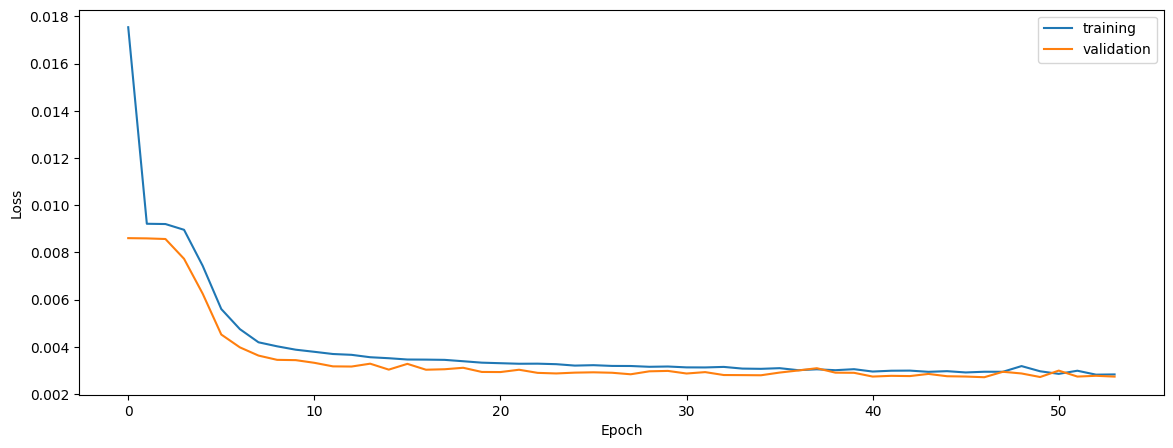

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8311725255303132
0.82728145678749
0.8166124478136499


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8318604666006798
0.8416985833518641
0.8243974828843035


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8303467610862995
0.8380820494404958
0.8211385118409548


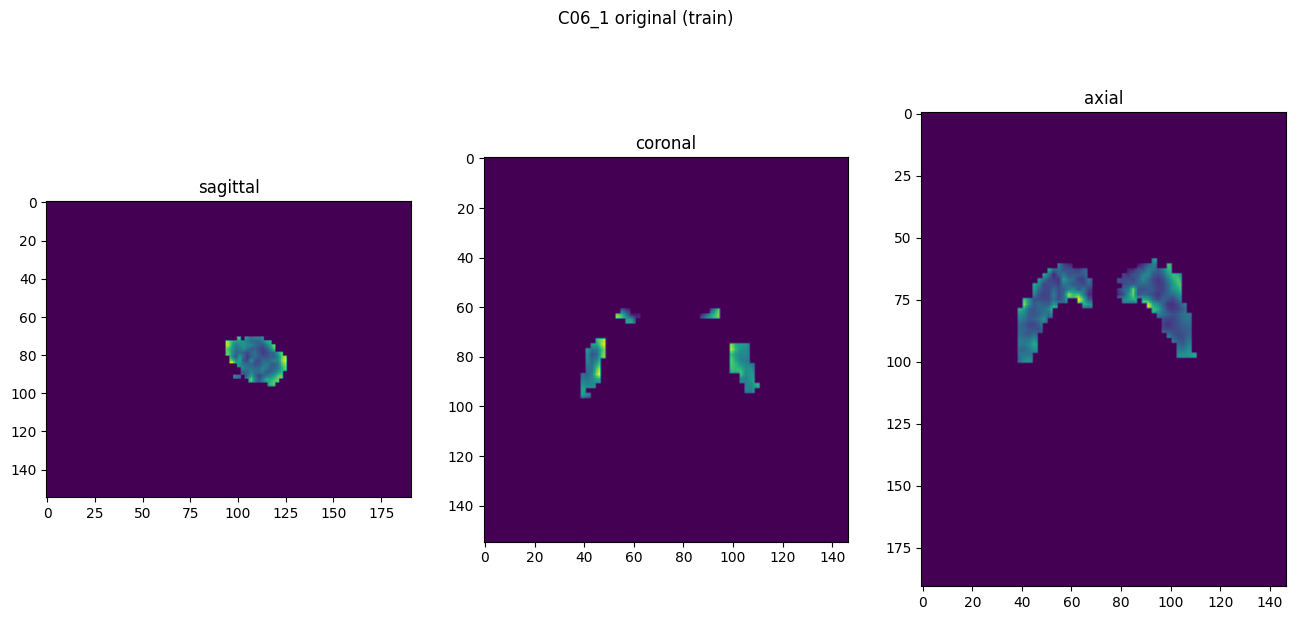

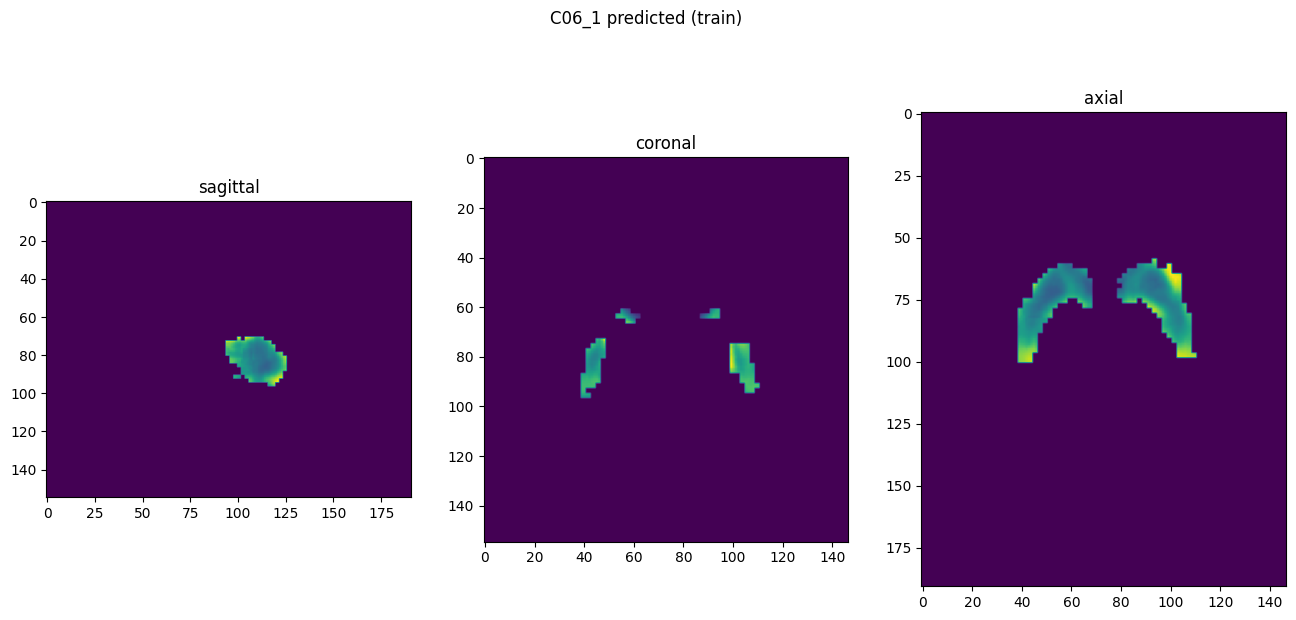

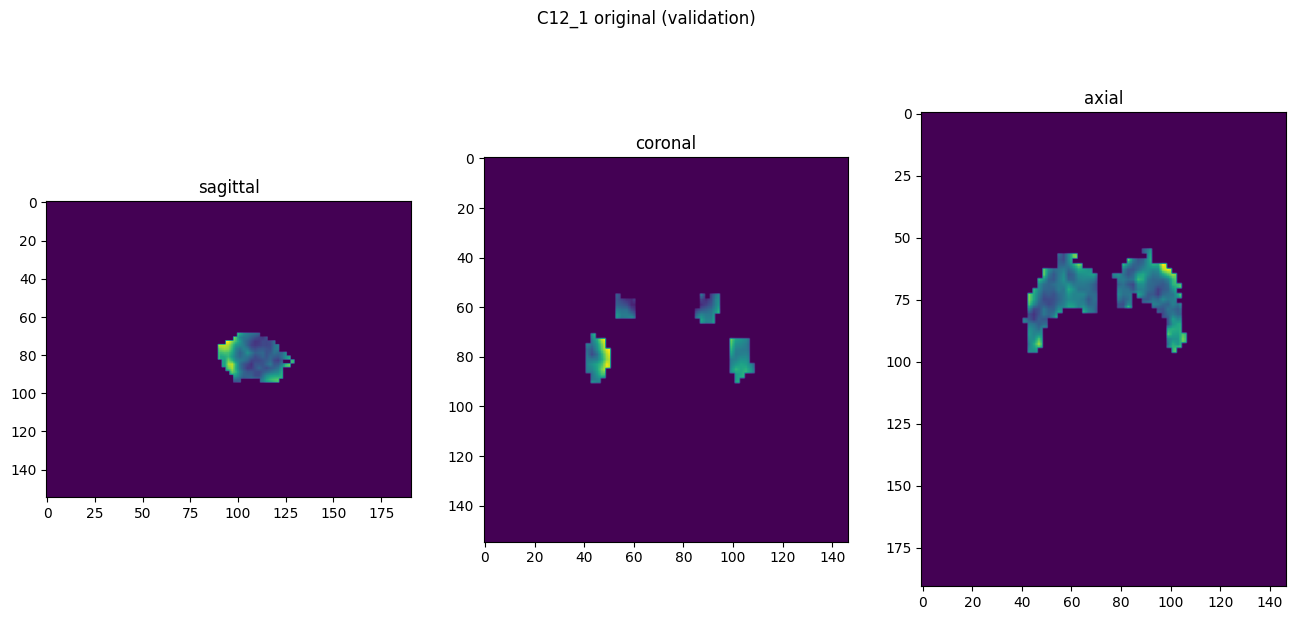

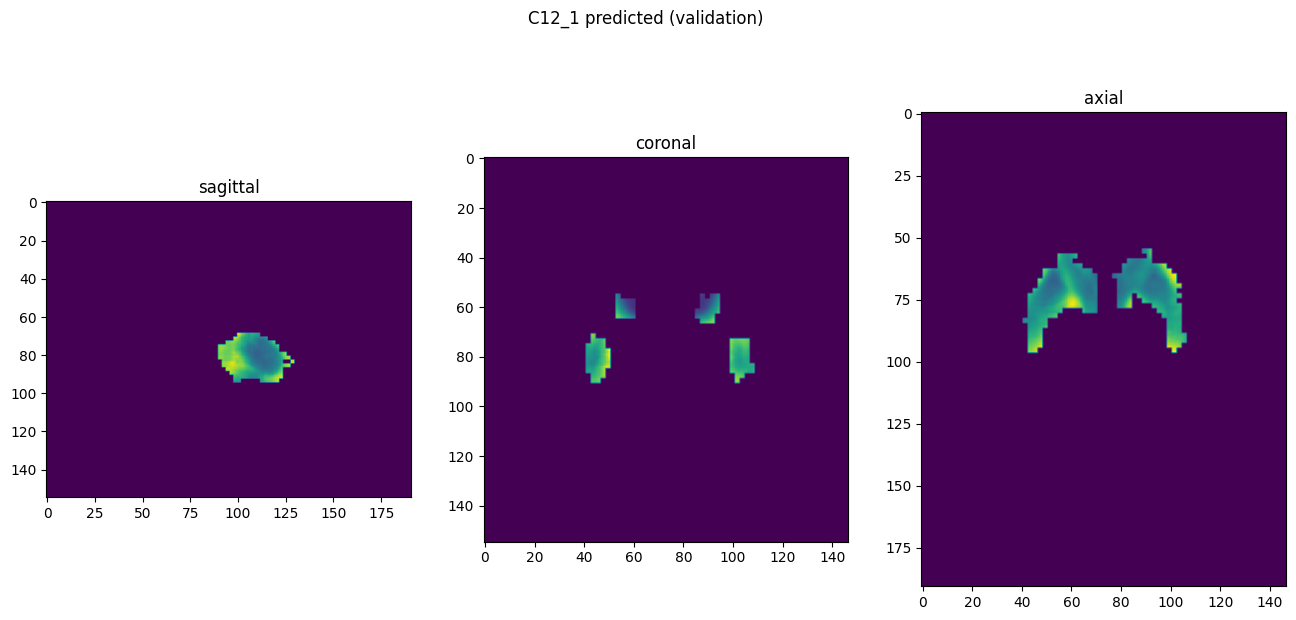

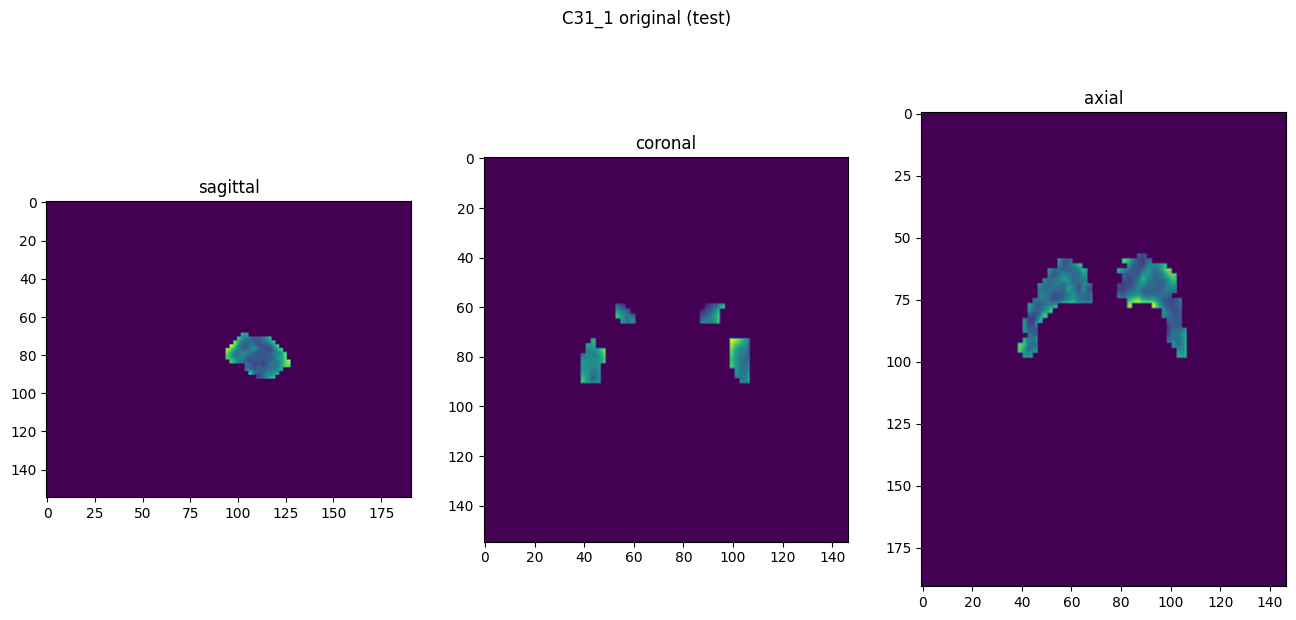

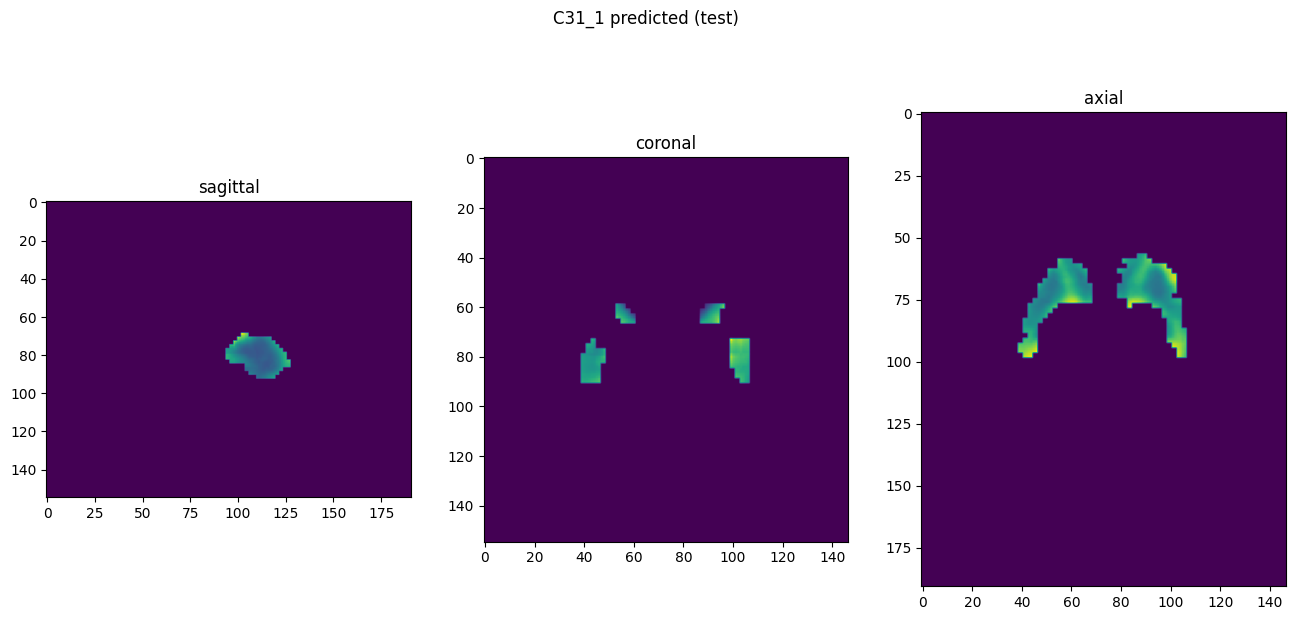

In [10]:
showResults(model, gen, threshold=None, background=False)